# deep-muse (ver 0.8) [WIP]

***

# Advanced text-to-music generator

***

## Inspired by https://github.com/lucidrains/deep-daze

## Powered by tegridy-tools TMIDI Optimus Processors

***

### Project Los Angeles
### Tegridy Code 2021

***

# Setup environment

In [1]:
#@title Install dependencies
!git clone https://github.com/Tegridy-Code/tegridy-tools
!pip install tqdm

# for data
!pip install fuzzywuzzy[speedup]

# for listening
!apt install fluidsynth #Pip does not work for some reason. Only apt works
!pip install midi2audio

# packages below are for plotting pianoroll only
# they are not needed for anything else
!pip install pretty_midi
!pip install librosa
!pip install matplotlib

Cloning into 'tegridy-tools'...
remote: Enumerating objects: 2460, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 2460 (delta 16), reused 0 (delta 0), pack-reused 2426
Receiving objects: 100% (2460/2460), 117.17 MiB | 23.09 MiB/s, done.
Resolving deltas: 100% (1588/1588), done.
     |████████████████████████████████| 50 kB 4.1 MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149860 sha256=8c871a42308c0185e136c2a9c9bfd180ba693ecfdc319378860d7d2d5ce2962b
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-levenshtein
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd


In [2]:
#@title Load needed modules
print('Loading needed modules. Please wait...')

import sys
import os
import json
import secrets
import copy

os.chdir('/content/tegridy-tools/tegridy-tools/')
import TMIDI
os.chdir('/content/')

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from itertools import islice, accumulate

from pprint import pprint

import tqdm.auto
from tqdm import auto
from midi2audio import FluidSynth
from IPython.display import display, Javascript, HTML, Audio

# only for plotting pianoroll
import pretty_midi
import librosa.display
import matplotlib.pyplot as plt

from google.colab import output, drive

print('Creating Dataset dir...')
if not os.path.exists('/content/Dataset'):
    os.makedirs('/content/Dataset')

os.chdir('/content/')
print('Loading complete. Enjoy! :)')

Loading needed modules. Please wait...
Creating Dataset dir...
Loading complete. Enjoy! :)


# Prep statistics dictionary

In [3]:
#@title Download English Karaoke MIDI classification model
%cd /content/
!wget --no-check-certificate -O Karaoke-English-Full.pickle "https://onedrive.live.com/download?cid=8A0D502FC99C608F&resid=8A0D502FC99C608F%2118485&authkey=ABXca9Cn2L-64UE"

/content
--2021-10-21 23:27:09--  https://onedrive.live.com/download?cid=8A0D502FC99C608F&resid=8A0D502FC99C608F%2118485&authkey=ABXca9Cn2L-64UE
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://wz1z3g.dm.files.1drv.com/y4mJUn3OdD009PSyz_DgEDlMehgMJpJWiP4FguEyEc1u6EuxJ0ucCK4rtVZgJn8TwSQJNY2gJ2u9cVEfmVmAzV49xDE8o-zv7zOcNM8MdBz7Dy32HqZ0QtPbagQ5dGYvl391si9yHp8ovYrekRvRfZmw0SRVVl8axhNId8J43uzAQMsvB40zHrrg6rm7TWsX29VjabP2Aonf07fPCQQ8JYQSw/Karaoke-English-Full.pickle?download&psid=1 [following]
--2021-10-21 23:27:09--  https://wz1z3g.dm.files.1drv.com/y4mJUn3OdD009PSyz_DgEDlMehgMJpJWiP4FguEyEc1u6EuxJ0ucCK4rtVZgJn8TwSQJNY2gJ2u9cVEfmVmAzV49xDE8o-zv7zOcNM8MdBz7Dy32HqZ0QtPbagQ5dGYvl391si9yHp8ovYrekRvRfZmw0SRVVl8axhNId8J43uzAQMsvB40zHrrg6rm7TWsX29VjabP2Aonf07fPCQQ8JYQSw/Karaoke-English-Full.pickle?download&psid=1
Resolving wz1z3g.dm.

In [4]:
#@title Load and prep the model

print('Loading the Karaoke model. Please wait...')
data = TMIDI.Tegridy_Any_Pickle_File_Loader('/content/Karaoke-English-Full')

print('Done!')
print('Prepping data...')

kar_ev_f = data[2]

kar = []
karaoke = []

for k in auto.tqdm(kar_ev_f):
  k.sort(reverse=False, key=lambda x: x[1])
  for kk in k:
    
    if kk[0] == 'note' or kk[0] == 'text_event':
      kar.append(kk)

kar_words = []
for o in auto.tqdm(kar):
  if o[0] != 'note':
    kar_words.append(str(o[2]).lower())

print('Done! Enjoy! :)')

Loading the Karaoke model. Please wait...
Tegridy Pickle File Loader
Loading the pickle file. Please wait...
Done!
Prepping data...


  0%|          | 0/2374 [00:00<?, ?it/s]

  0%|          | 0/8719318 [00:00<?, ?it/s]

Done! Enjoy! :)


# Generate Music



In [22]:
#@title Generate Music from the lyrics below

#@markdown NOTE: No symbols, special chars, commas, etc., please.

#@markdown ProTip: Be as ambiguous and general as possible for best results as the current dictionary is too small for anything specific.

randomize_words_matching = False #@param {type:"boolean"}

lyric1 = 'I have been going through some things (oh)' #@param {type:"string"}
lyric2 = 'I struggle with my inner man' #@param {type:"string"}
lyric3 = "I hustle, I'll do what I can to get this money" #@param {type:"string"}
lyric4 = 'Blaq Tuxedo' #@param {type:"string"}

lyric5 = 'Don Dada on the, Don Dada on the beat' #@param {type:"string"}
#lyric6 = 'I know you were right believing for so long' #@param {type:"string"}
#lyric7 = 'I am all out of love what am I without you' #@param {type:"string"}
#lyric8 = 'I cant be too late to say that I was so wrong' #@param {type:"string"}

text = [lyric1, lyric2,lyric1,lyric2, lyric3, lyric4,lyric2]

song = []

words_lst = 'sadness, happiness, trip'

print('=' * 100)

print('Deep-Muse Text to Music Generator')
print('Starting up...')

print('=' * 100)

for t in auto.tqdm(text):
  txt = t.lower().split(' ')
  
  kar_words_split = list(TMIDI.Tegridy_List_Slicer(kar_words, len(txt)))
  
  ratings = []

  for k in kar_words_split:
    ratings.append(fuzz.ratio(txt, k))
  
  if randomize_words_matching:
    
    try:
      ind = ratings.index(secrets.choice([max(ratings)-5, max(ratings)-4, max(ratings)-3, max(ratings)-2, max(ratings)-1, max(ratings)]))
    except:
      ind = ratings.index(max(ratings))
  
  else:
    ind = ratings.index(max(ratings))

  words_list = kar_words_split[ind]
  pos = ind * len(txt)
  

  print(words_list)

  words_lst += ' '.join(words_list) + chr(10)

  c = 0
  for i in range(len(kar)):
    if kar[i][0] != 'note':
      if c == pos:
        idx = i
        break

    if kar[i][0] != 'note':
      c += 1
 
  c = 0
  for i in range(idx, len(kar)):
    if kar[i][0] != 'note':
      if c == len(txt):
        break

    if kar[i][0] == 'note':
      song.append(kar[i])

    if kar[i][0] != 'note':
      c += 1
      song.append(kar[i])

so = [y for y in song if len(y) > 3]
if so != []: sigs = TMIDI.Tegridy_MIDI_Signature(so, so)

print('=' * 100)

print(sigs[0])

print('=' * 100)

song1 = []
p = song[0]
p[1] = 0
time = 0

song.sort(reverse=False, key=lambda x: x[1])

for i in range(len(song)-1):

    ss = copy.deepcopy(song[i])
    if song[i][1] != p[1]:
      
      if abs(song[i][1] - p[1]) > 1000:
        time += 300
      else:
        time += abs(song[i][1] - p[1])

      ss[1] = time 
      song1.append(ss)
      
      p = copy.deepcopy(song[i])
    else:
      
      ss[1] = time
      song1.append(ss)
      
      p = copy.deepcopy(song[i])

pprint(words_lst, compact=True)
print('=' * 100)

Deep-Muse Text to Music Generator
Starting up...


  0%|          | 0/7 [00:00<?, ?it/s]

['of', 'day', 'search', 'ing', 'for', 'some', 'thing', 'to']
['in', 'love', 'with', 'you;', 'i', 'mean']
['of', 'day', 'search', 'ing', 'for', 'some', 'thing', 'to']
['in', 'love', 'with', 'you;', 'i', 'mean']
['love', 'and', "i'll", 'do', 'a', 'ny', 'thing', 'to', 'get', 'you', 'in']
['bl', 'ue']
['in', 'love', 'with', 'you;', 'i', 'mean']
[59004155, 104432, 198424, 351, 2139, 3, 30458, 53, 48654, 86]
('sadness, happiness, tripof day search ing for some thing to\n'
 'in love with you; i mean\n'
 'of day search ing for some thing to\n'
 'in love with you; i mean\n'
 "love and i'll do a ny thing to get you in\n"
 'bl ue\n'
 'in love with you; i mean\n')


# Convert generated music composition to MIDI file and download/listen to the output :)

In [23]:
#@title Convert to MIDI

TMIDI.Tegridy_SONG_to_MIDI_Converter(song1, output_file_name='/content/deep-muse-Output-MIDI')

Converting to MIDI. Please stand-by...
Done! Enjoy! :)


{'bank_select': [],
 'channels_by_track': [set(), {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}],
 'channels_total': {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11},
 'general_midi_mode': [],
 'nticks': 18581,
 'ntracks': 2,
 'num_notes_by_channel': {0: 21,
  1: 89,
  2: 68,
  3: 123,
  4: 18,
  5: 117,
  6: 81,
  7: 20,
  8: 8,
  10: 16,
  11: 3},
 'patch_changes_by_track': [{},
  {0: 0,
   1: 24,
   2: 32,
   3: 40,
   4: 42,
   5: 46,
   6: 56,
   7: 71,
   8: 73,
   9: 0,
   10: 0,
   11: 0,
   12: 0,
   13: 0,
   14: 0,
   15: 0}],
 'patch_changes_total': {0, 24, 32, 40, 42, 46, 56, 71, 73},
 'percussion': {},
 'pitch_range_by_track': [(0, 0), (26, 81)],
 'pitch_range_sum': 55,
 'pitches': {26: 8,
  27: 1,
  28: 9,
  29: 10,
  31: 12,
  32: 2,
  33: 27,
  35: 6,
  38: 20,
  39: 2,
  40: 21,
  41: 28,
  43: 38,
  45: 37,
  47: 9,
  50: 4,
  51: 5,
  52: 24,
  53: 5,
  54: 6,
  55: 9,
  57: 22,
  58: 2,
  59: 32,
  60: 9,
  62: 13,
  63: 3,
  64: 39,
  65: 6,
  66: 4,
  67: 17,
  69: 47,
  70: 3,
  71: 8

Playing and plotting composition...
Synthesizing the last output MIDI. Please stand-by... 


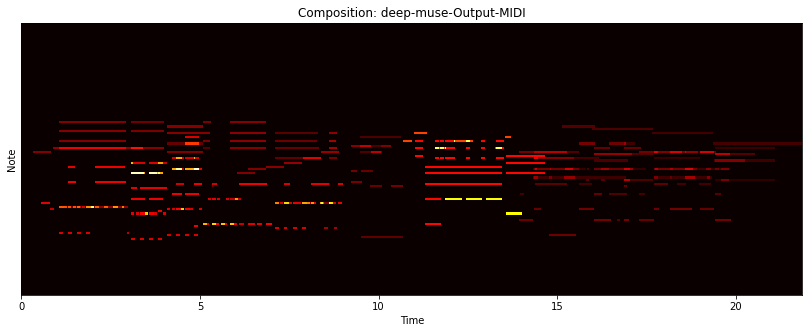

In [24]:
#@title Plot and listen to the last generated composition
#@markdown NOTE: May be very slow with the long compositions
fname = '/content/deep-muse-Output-MIDI'

fn = os.path.basename(fname + '.mid')
fn1 = fn.split('.')[0]
print('Playing and plotting composition...')

pm = pretty_midi.PrettyMIDI(fname + '.mid')

# Retrieve piano roll of the MIDI file
piano_roll = pm.get_piano_roll()

plt.figure(figsize=(14, 5))
librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=1, hop_length=160, sr=16000, cmap=plt.cm.hot)
plt.title('Composition: ' + fn1)

print('Synthesizing the last output MIDI. Please stand-by... ')
FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
Audio(str(fname + '.wav'), rate=16000)

# Congrats! You did it! :)